In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df=pd.read_csv('data.csv')
df.head()

,feature_1,feature_2,feature_3,feature_4,isVirus
0,-0.233467,0.308799,2.484015,1.732721,False
1,1.519003,1.238482,3.344450,0.783744,False
2,0.400640,1.916748,3.291096,-0.918519,False
3,-1.616474,0.209703,1.461544,-0.291837,False
4,1.480515,5.299829,2.640670,1.867559,True


# Distribution of Data

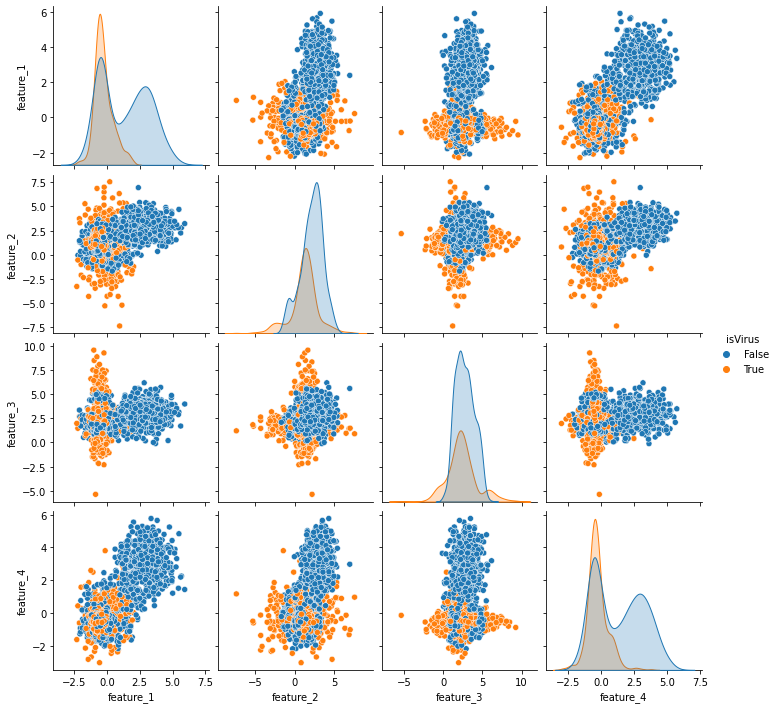

In [3]:
sns.pairplot(df,hue="isVirus")

<AxesSubplot:ylabel='isVirus'>

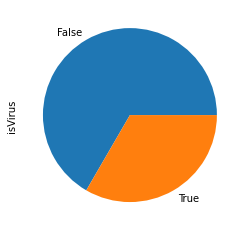

In [4]:
df.isVirus.value_counts().plot.pie()

# Data Preperation

In [5]:
print('Empty values in columns:')
for col in df.columns:
    c = (df[col].isna()).sum()
    print(col,c)

Empty values in columns:
feature_1 102
feature_2 100
feature_3 106
feature_4 102
isVirus 0


In [6]:
len(df.index)

1999

In [7]:
#dropping between 100 and 400 rows of 2000 rows is not logical then handle missing variables with median values
#missing values colud be predicted with 4 different regressor or be filled with current values
for col in df.iloc[:,:-1].columns:
    df[col] = df[col].fillna(value=df[col].median())

In [8]:
print('Empty values in columns:')
for col in df.columns:
    c = (df[col].isna()).sum()
    print(col,c)

Empty values in columns:
feature_1 0
feature_2 0
feature_3 0
feature_4 0
isVirus 0


In [9]:
#standardization
df.iloc[:,:-1]=(df.iloc[:,:-1]-df.iloc[:,:-1].mean())/df.iloc[:,:-1].std()

# Distribution of Data After Data Preperation

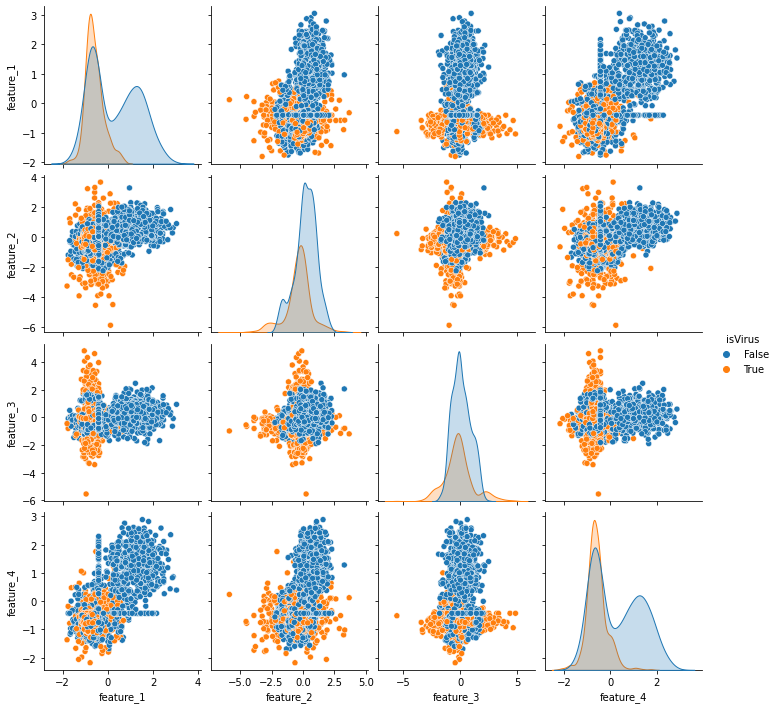

In [10]:
sns.pairplot(df,hue="isVirus")

# Feature Analysing

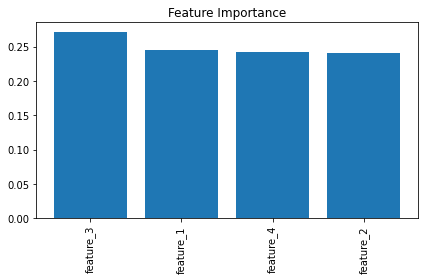

In [11]:
#random forest classifier feauture importances
x=df.iloc[:,:-1]
y=df.isVirus
rf = RandomForestClassifier(criterion='entropy')
 
rf.fit(x, y)

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
 
plt.title('Feature Importance')
plt.bar(range(x.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(x.shape[1]), x.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [12]:
#with chi square 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

xN = MinMaxScaler().fit_transform(x)
chi_selector = SelectKBest(chi2, k=3)
chi_selector.fit(xN, y)
chi_support = chi_selector.get_support()
chi_features = x.loc[:,chi_support].columns.tolist()
print(str(len(chi_features)), 'selected features')
print(chi_features)

3 selected features
['feature_1', 'feature_2', 'feature_4']


In [13]:
xN = MinMaxScaler().fit_transform(x)
chi_selector = SelectKBest(chi2, k=2)
chi_selector.fit(xN, y)
chi_support = chi_selector.get_support()
chi_features = x.loc[:,chi_support].columns.tolist()
print(str(len(chi_features)), 'selected features')
print(chi_features)

2 selected features
['feature_1', 'feature_4']


# Model 

As seen in the graphs above, classes are not well seperated completely, therefore SVM is not a good choice.
I'll try Naive Bayes method first because of it's real time prediction feature.

Acc: 0.6813406703351675 
Pre: 0.5134892086330936 
Rec: 0.856071964017991 
F1: 0.6419336706014616


[Text(0, 0.5, 'Safe'), Text(0, 1.5, 'Virus')]

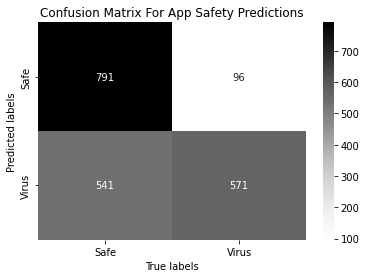

In [14]:
model=GaussianNB()
params = {'var_smoothing': np.logspace(0,-9, num=100)}
nb = GridSearchCV(estimator=model, param_grid=params, cv=5).fit(x,y)
predictions = nb.predict(x)
acc = accuracy_score(y, predictions)
pre = precision_score(y, predictions)
rec = recall_score(y, predictions)
f1 = f1_score(y, predictions)
print("Acc:",acc,"\nPre:",pre,"\nRec:",rec,"\nF1:",f1)

cm = confusion_matrix(predictions,y)
ax= plt.subplot()
sns.heatmap(cm, cmap="Greys", annot=True, fmt='g', ax=ax);  
ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
ax.set_title('Confusion Matrix For App Safety Predictions'); 
ax.xaxis.set_ticklabels(['Safe','Virus'])
ax.yaxis.set_ticklabels(['Safe','Virus'])

Got good result on predicting safe ones, unfortunately not on harmful apps. It could be the first level predictor of 2 level  security(1st level good with catching safe apps, 2nd level good with catching virus containing apps).

Possible reasons that it does not perform well enough:
*Dataset
*Naive bayes algorithm :itself
*Picking all the features(using subsets of features did not help)

Acc: 0.885 
Pre: 0.8350515463917526 
Rec: 0.856071964017991 
F1: 0.8244274809160306


[Text(0, 0.5, 'Safe'), Text(0, 1.5, 'Virus')]

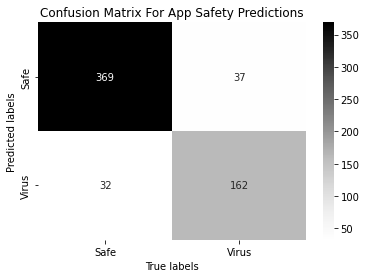

In [15]:
#random forest 
x=df.iloc[:,:-1]
y=df.isVirus
rf = RandomForestClassifier(criterion='entropy')
X_train, X_test, y_train, y_test = train_test_split(
             x, y, test_size = 0.3, random_state=11)
rf.fit(X_train, y_train)
 
predictions = rf.predict(X_test)
acc = accuracy_score(y_test, predictions)
pre = precision_score(y_test, predictions)
rec1 = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Acc:",acc,"\nPre:",pre,"\nRec:",rec,"\nF1:",f1)

cm = confusion_matrix(predictions,y_test)
ax= plt.subplot()
sns.heatmap(cm, cmap="Greys", annot=True, fmt='g', ax=ax);  
ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
ax.set_title('Confusion Matrix For App Safety Predictions'); 
ax.xaxis.set_ticklabels(['Safe','Virus'])
ax.yaxis.set_ticklabels(['Safe','Virus'])

Acc: 0.984992496248124 
Pre: 0.989247311827957 
Rec: 0.856071964017991 
F1: 0.9772382397572079


[Text(0, 0.5, 'Safe'), Text(0, 1.5, 'Virus')]

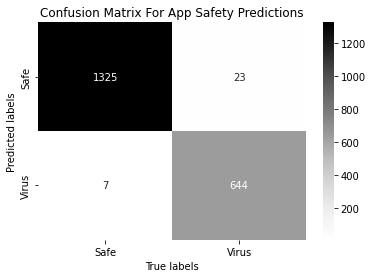

In [16]:
#with tuning
model = RandomForestClassifier()
params = {'bootstrap': [True], 'max_depth': [5,10,15,50,150,300, None], 
          'max_features': ['auto', 'log2'], 'n_estimators': [3,5,7]}
randomForrest = GridSearchCV(estimator=model, param_grid=params, cv=10).fit(x,y)
predictions = randomForrest.predict(x)
acc = accuracy_score(y, predictions)
pre = precision_score(y, predictions)
rec1 = recall_score(y, predictions)
f1 = f1_score(y, predictions)
print("Acc:",acc,"\nPre:",pre,"\nRec:",rec,"\nF1:",f1)

cm = confusion_matrix(predictions,y)
ax= plt.subplot()
sns.heatmap(cm, cmap="Greys", annot=True, fmt='g', ax=ax);  
ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
ax.set_title('Confusion Matrix For App Safety Predictions'); 
ax.xaxis.set_ticklabels(['Safe','Virus'])
ax.yaxis.set_ticklabels(['Safe','Virus'])